In [1]:
import torch
import numpy as np
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Experiment Details (see Setup and Background)
P = 113 # (a+b) mod P
n_tokens = P+1 # 0,...,P-1,'='
seq_len = 3 # a,b,'='
d_embed = 128 # token embedding dimension (also need "learned positional embeddings")
n_heads = 4 # number of attention heads
d_mlp = 512 # hidden units in MLP
train_split = .3 # use only 30% of all possible pairs to train model
n_layers = 1 # only decoder layers

# Preprocessing

In [3]:
input_vals = np.arange(P)  # Array of input numbers from 0 to P-1

# Create a grid of all possible pairs of digits
pairs = np.meshgrid(input_vals, input_vals)

# Reshape the arrays and stack them horizontally to create a 2D array of pairs
pairs_array = np.column_stack((pairs[0].ravel(), pairs[1].ravel()))
output_array = np.mod(np.sum(pairs_array,axis=1),P)

eq_col = np.ones(len(pairs_array))*P # column of P,...,P since P = '='
input_array = np.concatenate((pairs_array,eq_col.reshape((len(eq_col),1))),axis=1)
assert(input_array.shape==(P**2,3))
assert(output_array.shape==(P**2,))

In [4]:
class MTDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset    
    self.source = np.array(input_array, dtype=int)
    self.target = np.array(output_array, dtype = int)
    
  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]
  
  def __len__(self):
    # returns length of data
    return len(self.source)

In [5]:
np.random.seed(42)
dataset = MTDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.7
TEST_SIZE = int(NUM_INSTANCES * TEST_RATIO)

BATCH_SIZE=NUM_INSTANCES-TEST_SIZE # FULL BATCH = TRAIN SIZE
assert(P**2==NUM_INSTANCES)

In [6]:
indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = torch.utils.data.SubsetRandomSampler(train_idx), torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)

In [7]:
generator1 = torch.Generator().manual_seed(42)
train_split, test_split = torch.utils.data.random_split(range(NUM_INSTANCES), [1-TEST_RATIO,TEST_RATIO], generator=generator1)
 # train and test split must be disjoint!
assert(len(set(train_split).intersection(set(test_split)))==0)

# Model Training

In [8]:
from torch import nn
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0, max_len=seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [9]:
class TransformerNet(torch.nn.Module):
    def __init__(self,n_tokens,seq_len,d_embed,d_mlp,n_heads):
        super(TransformerNet,self).__init__()
        self.We = nn.Embedding(n_tokens,d_embed)
        self.Pe = PositionalEncoding(d_embed, max_len = seq_len)
        
        # Decoder: Attention head
        self.attn1 = nn.MultiheadAttention(d_embed,n_heads,dropout=0,bias=False)
        # Decoder: MLP
        self.lin1 = nn.Linear(d_embed,d_mlp)
        self.lin2 = nn.Linear(d_mlp,d_embed)
        
        # Unembedding (not tied to embedding)
        self.Wu = nn.Linear(d_embed,n_tokens,bias=False)
        
    def forward(self,src):
        # token
        x0 = self.Pe(self.We(src).permute(1,0,2))
        # x0 = token embedding + positional embedding
        x1 = x0[2]+self.attn1(x0,x0,x0,need_weights=False)[0][2]
        # x1: residual stream from first two tokens is irrelevant once '=' has attended to those tokens, so we only consider idx=2
        x2 = x1+self.lin2(self.lin1(x1))
        # x2: feed-forward (MLP) part of decoder
        logits = self.Wu(x2)
        return logits

In [10]:
model = TransformerNet(n_tokens,seq_len,d_embed,d_mlp,n_heads)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1)

In [11]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
%%time
NUM_EPOCHS = 40000
train_loss = []
train_acc = []
test_loss = []
test_acc = []
acc = lambda lgits,truth: (torch.sum(torch.argmax(lgits,1)==truth)/len(lgits)).item()
for epoch in tqdm(range(NUM_EPOCHS)):
    # train loss
    x,y = next(iter(train_loader))
    logits = model(x)
    loss = criterion(logits,y)
    train_loss.append(loss.item())
    train_acc.append(acc(logits,y))
    
    # test loss
    x,y = next(iter(test_loader))
    logits = model(x)
    loss2 = criterion(logits,y)
    test_loss.append(loss2.item())
    test_acc.append(acc(logits,y))
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|                                                 | 0/40000 [00:00<?, ?it/s]Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

 99%|██████████████████████████████████▋| 39641/40000 [4:49:36<01:27,  4.10it/s]

# Results

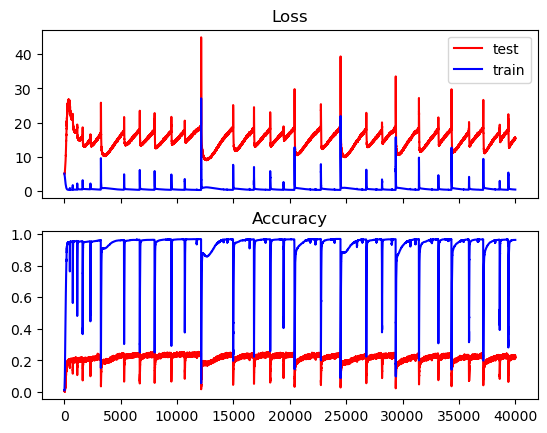

In [15]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].set_title("Loss")
ax[0].plot(range(1, NUM_EPOCHS+1), test_loss, 'r-',label='test')
ax[0].plot(range(1, NUM_EPOCHS+1), train_loss, 'b-',label='train')
ax[0].legend()
ax[1].set_title("Accuracy")
ax[1].plot(range(1, NUM_EPOCHS+1), test_acc, 'r-')
ax[1].plot(range(1, NUM_EPOCHS+1), train_acc, 'b-')
plt.show()